In [1]:
!nvidia-smi

Tue Oct 15 17:16:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
import numpy as np
from numba import njit
import time

@njit
def mat_mul_cpu(A, B):
    n = A.shape[0]
    m = A.shape[1]
    p = B.shape[1]
    C = np.zeros((n, p))
    for i in range(n):
        for j in range(p):
            for k in range(m):
                C[i, j] += A[i, k] * B[k, j]
    return C

def test_mat_mul_cpu(A, B):
    start_time = time.time()
    C = mat_mul_cpu(A, B)
    end_time = time.time()
    return C, end_time - start_time

In [4]:
from numba import cuda

@cuda.jit
def mat_mul_gpu(A, B, C):
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

def test_mat_mul_gpu(A, B):
    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)
    C_device = cuda.device_array((A.shape[0], B.shape[1]))

    threadsperblock = (16, 16)
    blockspergrid_x = (A.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (B.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    start_time = time.time()
    mat_mul_gpu[blockspergrid, threadsperblock](A_device, B_device, C_device)
    cuda.synchronize()
    end_time = time.time()

    C = C_device.copy_to_host()
    return C, end_time - start_time

Matrix size 100
CPU time: 0.001307 seconds
GPU time: 0.000406 seconds
Results are correct!
----------------------------------------
Matrix size 500
CPU time: 0.443843 seconds
GPU time: 0.006769 seconds
Results are correct!
----------------------------------------
Matrix size 1000
CPU time: 1.569118 seconds
GPU time: 0.067391 seconds
Results are correct!
----------------------------------------
Matrix size 1500
CPU time: 4.891590 seconds
GPU time: 0.174454 seconds
Results are correct!
----------------------------------------
Matrix size 2000
CPU time: 15.807101 seconds
GPU time: 0.419402 seconds
Results are correct!
----------------------------------------


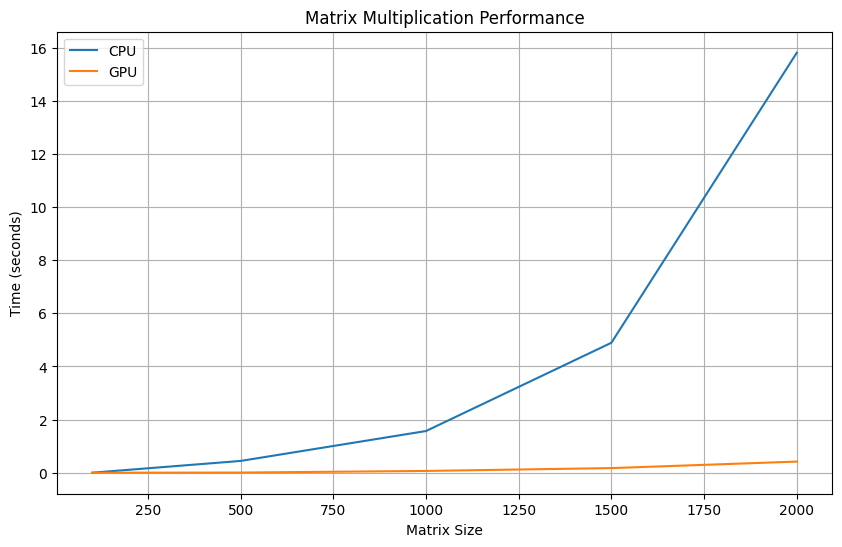

In [6]:
import matplotlib.pyplot as plt

def run_experiments():
    sizes = [100, 500, 1000, 1500, 2000]
    results = []

    for size in sizes:
        A = np.random.rand(size, size)
        B = np.random.rand(size, size)

        C_cpu, time_cpu = test_mat_mul_cpu(A, B)
        C_gpu, time_gpu = test_mat_mul_gpu(A, B)

        print(f"Matrix size {size}")
        print(f"CPU time: {time_cpu:.6f} seconds")
        print(f"GPU time: {time_gpu:.6f} seconds")

        if np.allclose(C_cpu, C_gpu):
          print("Results are correct!")
        else:
          print("Results are incorrect!")

        print("-"*40)
        results.append((size, time_cpu, time_gpu))

    return results

def plot_results(results):
    sizes = [r[0] for r in results]
    times_cpu = [r[1] for r in results]
    times_gpu = [r[2] for r in results]

    plt.figure(figsize=(10, 6))
    plt.plot(sizes, times_cpu, label='CPU')
    plt.plot(sizes, times_gpu, label='GPU')
    plt.xlabel('Matrix Size')
    plt.ylabel('Time (seconds)')
    plt.title('Matrix Multiplication Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

results = run_experiments()
plot_results(results)